In [1]:
# Import pandas and numpy
import pandas as pd
import numpy as np

# Import seaborn and matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Import OneHotEncoder, MinMaxScaler, and FunctionTransformer from sklearn.preprocessing
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler 

# Import Pipeline and FeatureUnion
from sklearn.pipeline import Pipeline, FeatureUnion

# Import train_test_split from sklearn.model_selection
from sklearn.model_selection import train_test_split

# Import LogisticRegression from sklearn.linear_model
from sklearn.linear_model import LogisticRegression

# Import LinearSVC from sklearn.svm
from sklearn.svm import LinearSVC

# Import DecisionTreeClassifier from sklearn.tree
from sklearn.tree import DecisionTreeClassifier

# Import RandomForestClassifier from sklearn.ensemble
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# Import xgboost
import xgboost as xgb

# Import roc_auc_score from sklearn.metrics
from sklearn.metrics import roc_auc_score

In [2]:
# Import the final working data (encoded)
train_df = pd.read_csv('./Intermediate_Data/encoded_train.csv', encoding='utf-8', index_col=0)

# Import the test data
test_df = pd.read_csv('./Intermediate_Data/encoded_test.csv', encoding='utf-8', index_col=0)

### Model Approach
For the development of this model, I will be using pipelines with an encoding step (OneHotEncoder) and a modeling step (LogisticRegression/LinearSVC/DecisionTreeClassifier/RandomForestClassifier)). I will attempt a combination of different variables (exclude some of the variables that were determined as poor predictors of the target variable). Additionally, I may choose to apply feature importance to the non-binary categorical data to do some feature selection if the model is having difficulty training.

Additionally, I may choose to performing some preprocessing steps on the numerical data depending on the performance of the model.

### Metrics
For the Kaggle competition, the scoring is done via area under the ROC curve

#### Note that this data is 8% target data and 92% non-target data. I am dealing with an imbalanced dataset.

In [3]:
# Sanity Check
# Target data should only be missing TARGET column
assert len(train_df.columns) == (len(test_df.columns) + 1)

In [4]:
train_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,...,ONGOING_CREDIT,TOTAL_CLOSED,CLOSED_CREDIT,MONTHS_BALANCE,SK_DPD,NET_PAID,PREV_CREDIT,DAYS_TERMINATION,NET_PAYMENT,PAYMENT_TIME
0,100002,1,0,1,202500.0,406597.5,24700.5,0,7,4,...,2.0,383067.0,6.0,0.0,0.0,0.0,3402045.0,-17.0,0.000,-388.0
1,100003,0,0,0,270000.0,1293502.5,35698.5,1,4,1,...,1.0,207400.5,3.0,0.0,0.0,0.0,10159641.0,-527.0,0.000,-179.0
2,100004,0,1,1,67500.0,135000.0,6750.0,0,7,4,...,0.0,189037.8,2.0,0.0,0.0,0.0,60318.0,-714.0,0.000,-23.0
3,100006,0,0,1,135000.0,312682.5,29686.5,0,7,4,...,0.0,0.0,0.0,-1.0,0.0,0.0,3745395.0,0.0,0.000,-310.0
4,100007,0,0,1,121500.0,513000.0,21865.5,0,7,4,...,0.0,146250.0,1.0,0.0,0.0,0.0,9733149.0,0.0,-29857.365,-240.0


In [5]:
# Define the categorical and numerical column

# Define the numerical columns. All the dtype float64s are numerical columns
NUMERICAL = [col for col in train_df if train_df[col].dtype == 'float64']

# I'll define the additional numerical columns here
ADD_NUMERICAL = ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'DOCUMENTS']

# Define the complete numerical list
NUMERICAL += ADD_NUMERICAL

# Define the categorical columns. All columns not found in the NUMERICAL list
CATEGORICAL = [col for col in train_df if col not in NUMERICAL]

# Sanity Check
assert len(train_df.columns) == (len(NUMERICAL) + len(CATEGORICAL))

In [6]:
# Remove the SK_ID_CURR and TARGET from the list of categorical columns
for col in ['SK_ID_CURR', 'TARGET']:
    CATEGORICAL.remove(col)

In [7]:
# Remove SK_ID_cURR??? since it's supposed to be the index not a training variable

# Split the data into X(variables) and y(target)
X = train_df.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = train_df['TARGET']

# Create the dummy variables and remove the original column from the X data
# for col in CATEGORICAL:
#     group_dummies = pd.get_dummies(X[col]).rename(columns=lambda x: col + str(x))
#     X = X.join(group_dummies)
#     del X[col]

To determine feature importance, I can't use the Pipeline. I will manually fit my data into a RandomForestClassifier model and use that to determine feature importance.

Unfortunately, I could not perform the feature importance on both the categorical and numerical data simultaneously.

In [8]:
# Fit the numerical data to the MinMaxScaler()
NUMERICAL_X_train = StandardScaler().fit_transform(X[NUMERICAL])

In [9]:
NUMERICAL_df = pd.DataFrame(NUMERICAL_X_train, columns=NUMERICAL)

In [10]:
CATEGORICAL_df = X[CATEGORICAL]

for col in CATEGORICAL:
    group_dummies = pd.get_dummies(CATEGORICAL_df[col]).rename(columns=lambda x: col + str(x))
    CATEGORICAL_df = CATEGORICAL_df.join(group_dummies)
    del CATEGORICAL_df[col]

In [11]:
# Fit the numerical data to the RandomForestClassifier()
rf = RandomForestClassifier().fit(NUMERICAL_df, y)

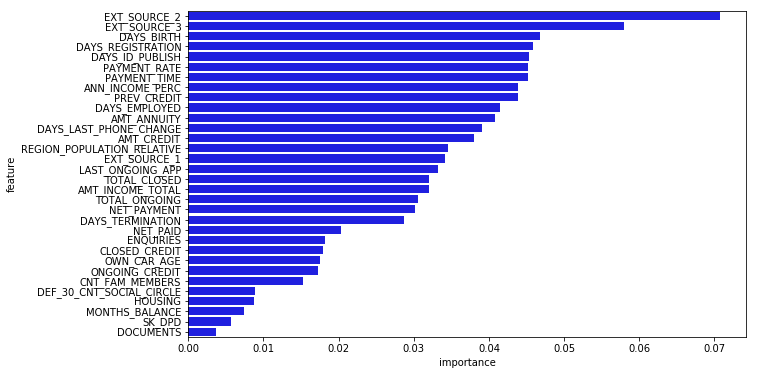

In [12]:
# Extract the feature importances and zip it with the columns into a dataframe
importances = rf.feature_importances_
features = pd.DataFrame({'feature': NUMERICAL, 'importance': importances})
features.sort_values(by='importance', ascending=False, inplace=True)

# Display a horizontal barplot with the feature importances
plt.figure(figsize=(10,6))
sns.barplot(x=features['importance'], y=features['feature'], color='blue', orient='h')

It may be a good idea to remove some of the less important features, namely, DOCUMENTS, SK_DPD, MONTHS_BALANCE, HOUSING, and DEF_30_CNT_SOCIAL_CIRCLE

In [13]:
# Fit the converted data to the RandomForestClassifier()
rf = RandomForestClassifier().fit(CATEGORICAL_df, y)

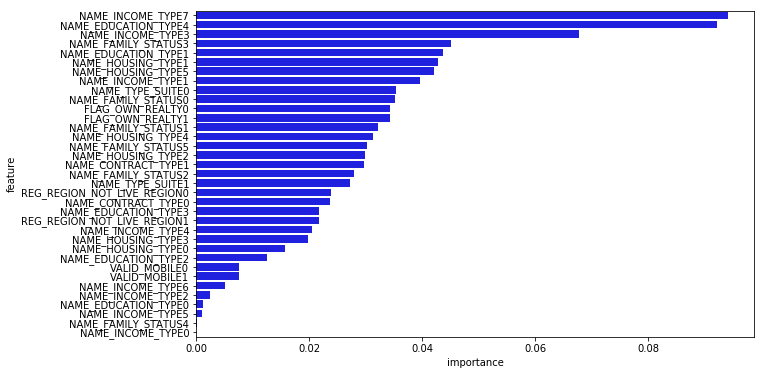

In [14]:
# Extract the feature importances and zip it with the columns into a dataframe
importances = rf.feature_importances_
features = pd.DataFrame({'feature': CATEGORICAL_df.columns, 'importance': importances})
features.sort_values(by='importance', ascending=False, inplace=True)

# Display a horizontal barplot with the feature importances
plt.figure(figsize=(10,6))
sns.barplot(x=features['importance'], y=features['feature'], color='blue', orient='h')

In [15]:
# Remove poor predictors from CATEGORICAL list (shown in t-test)
# CATEGORICAL.remove('VALID_MOBILE')

# # Remove poor predictors from NUMERICAL list (shown in t-test)
# for col in ['OWN_CAR_AGE', 'ENQUIRIES', 'SK_DPD', 'DAYS_TERMINATION']:
#     NUMERICAL.remove(col)

NUMERICAL_REMOVE = ['DOCUMENTS', 'SK_DPD', 'MONTHS_BALANCE', 'HOUSING', 'DEF_30_CNT_SOCIAL_CIRCLE']

# Remove poor predictors from NUMERICAL list (shown in feature importance)
for col in NUMERICAL_REMOVE:
    NUMERICAL.remove(col)
    
# Drop the numerical columns from the training and test data
X.drop(NUMERICAL_REMOVE, axis=1, inplace=True)

In [16]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [17]:
# Define a function to match the sample submission format
def submission(prediction):
    '''Creates the dataframe for the predictions and proper formatting'''
    submit = test_df[['SK_ID_CURR']].copy()
    submit['TARGET'] = prediction
    return submit

In [18]:
# Use FunctionTransformer to retrieve the categorical data and numerical data
get_categorical = FunctionTransformer(lambda x: x[CATEGORICAL], validate=False)

get_numerical = FunctionTransformer(lambda x: x[NUMERICAL], validate=False)

In [19]:
# Let's see if the function transformers work
assert len(CATEGORICAL) == len(get_categorical.fit_transform(train_df).columns)
assert len(NUMERICAL) == len(get_numerical.fit_transform(train_df).columns)

In [20]:
# Create a FeatureUnion with a nested pipeline
process_join_features = FeatureUnion(
        transformer_list=[
            ('numeric', Pipeline([
                ('selector', get_numerical),
                ('scaler', StandardScaler())
            ])),
            ('categorical', Pipeline([
                ('selector', get_categorical),
                ('encoder', OneHotEncoder())
            ]))
        ])

#### LogisticRegression

For hyperparamter tuning, I'll address mainly the regularization (L2 / Ridge in this case).

In [21]:
# # Create a list for regularization paramter tuning
# C_range = [0.001, 0.01, 0.1, 10, 100]

# # Create the Pipeline with LogisticRegression
# for C in C_range:
#     lrPipeline = Pipeline([
#         ('union', process_join_features),
#         ('clf', LogisticRegression(C = C))
#     ])
    
#     # Fit the Pipeline with the training data
#     lrPipeline.fit(X_train, y_train)
    
#     # Predict the probability on the test set
#     predicted_test_values = lrPipeline.predict_proba(X_test)[:, -1]
    
#     print ('{}:     {}'.format(C, roc_auc_score(y_test, predicted_test_values)))

Printed Results:

0.001:     0.7419420998140278
0.01:     0.7436368858167781
0.1:     0.7435282607426326
10:     0.7435395088182353
100:     0.743558843310297

For the regularization parameter C in LogisticRegression, it appears at 0.01 performed the best. (The lower the value the stronger the smoothing).

In [22]:
# Create the Pipeline with LogisticRegression
lrPipeline = Pipeline([
    ('union', process_join_features),
    ('clf', LogisticRegression(C = 0.01))
])

# Fit the Pipeline with the training data
lrPipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('numeric', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x00000204BB1AB950>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecat...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [23]:
predicted_train_values = lrPipeline.predict_proba(X_train)[:, -1]
predicted_test_values = lrPipeline.predict_proba(X_test)[:, -1]

In [24]:
print (roc_auc_score(y_test, predicted_test_values))

0.740231731131429


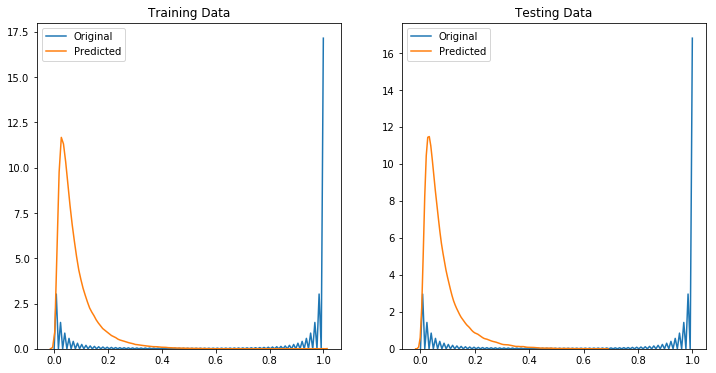

In [25]:
# Define the figure
fig, ax = plt.subplots(ncols=2, figsize=(12,6))

# Plot the training data
sns.kdeplot(y_train, ax=ax[0], label='Original').set_title('Training Data')
sns.kdeplot(predicted_train_values, ax=ax[0], label='Predicted')

# Plot the test data
sns.kdeplot(y_test, ax=ax[1], label='Original').set_title('Testing Data')
sns.kdeplot(predicted_test_values, ax=ax[1], label='Predicted')

In [26]:
# Generate the predictions from the pipeline
lrPredicted = lrPipeline.predict_proba(test_df)[:, -1]

# Create the submission dataframe
lrPredictions = submission(lrPredicted)

# Write the predictions to a csv file
lrPredictions.to_csv('./Submissions//lrPredictions.csv', encoding='utf-8', index=False)

Let's try AdaBoostClassifier with the LogisticRegression Model. I'll reuse the regularization parameter decided earlier.

In [27]:
# Create the Pipeline with AdaBoost and LogisticRegression
lrPipeline = Pipeline([
    ('union', process_join_features),
    ('clf', AdaBoostClassifier(LogisticRegression(C = 0.01)))
])

# Fit the Pipeline with the training data
lrPipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('numeric', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x00000204BB1AB950>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecat...    verbose=0, warm_start=False),
          learning_rate=1.0, n_estimators=50, random_state=None))])

In [28]:
predicted_train_values = lrPipeline.predict_proba(X_train)[:, -1]
predicted_test_values = lrPipeline.predict_proba(X_test)[:, -1]

In [29]:
print (roc_auc_score(y_test, predicted_test_values))

0.6145289485378502


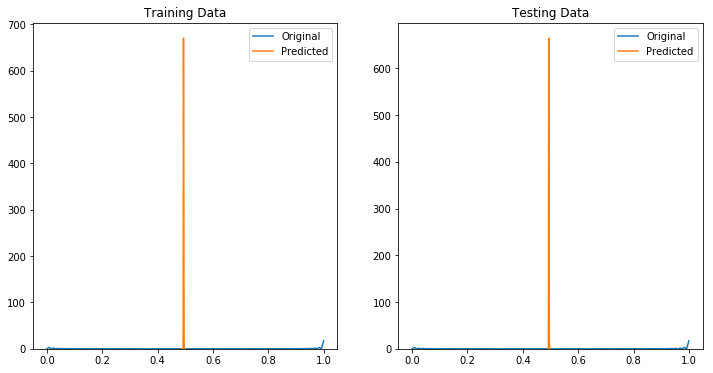

In [30]:
# Define the figure
fig, ax = plt.subplots(ncols=2, figsize=(12,6))

# Plot the training data
sns.kdeplot(y_train, ax=ax[0], label='Original').set_title('Training Data')
sns.kdeplot(predicted_train_values, ax=ax[0], label='Predicted')

# Plot the test data
sns.kdeplot(y_test, ax=ax[1], label='Original').set_title('Testing Data')
sns.kdeplot(predicted_test_values, ax=ax[1], label='Predicted')

#### Decision Tree

In [31]:
# Create the Pipeline with DecisionTreeClassifier
dtPipeline = Pipeline([
    ('union', process_join_features),
    ('clf', DecisionTreeClassifier())
])

# Fit the Pipeline with the training data
dtPipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('numeric', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x00000204BB1AB950>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecat...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])

In [32]:
predicted_train_values = dtPipeline.predict_proba(X_train)[:, -1]
predicted_test_values = dtPipeline.predict_proba(X_test)[:, -1]

In [33]:
print (roc_auc_score(y_test, predicted_test_values))

0.5433062359624115


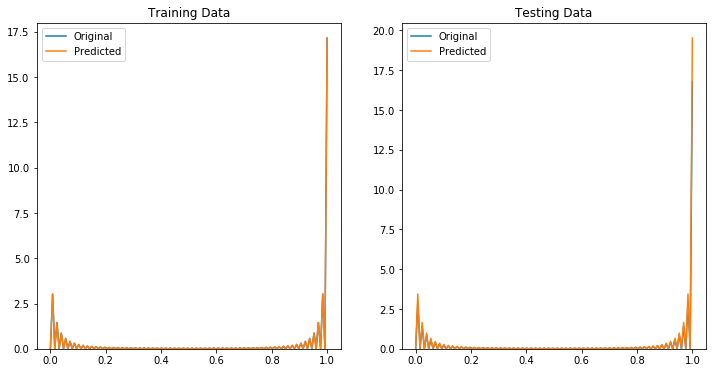

In [34]:
# Define the figure
fig, ax = plt.subplots(ncols=2, figsize=(12,6))

# Plot the training data
sns.kdeplot(y_train, ax=ax[0], label='Original').set_title('Training Data')
sns.kdeplot(predicted_train_values, ax=ax[0], label='Predicted')

# Plot the test data
sns.kdeplot(y_test, ax=ax[1], label='Original').set_title('Testing Data')
sns.kdeplot(predicted_test_values, ax=ax[1], label='Predicted')

In [35]:
# Generate the predictions from the pipeline
dtPredicted = dtPipeline.predict_proba(test_df)[:, -1]

# Create the submission dataframe
dtPredictions = submission(dtPredicted)

# Write the predictions to a csv file
dtPredictions.to_csv('./Submissions//dtPredictions.csv', encoding='utf-8', index=False)

#### RandomForestClassifier
Let's try some hyperparameter tuning with RandomForestClassifier.
I'll use GridSearchCV.

In [36]:
# params_rf = {
#             'clf__n_estimators': [100, 200, 300],
#             'clf__min_samples_leaf': [10, 15, 20]
# }

In [37]:
# # Create the Pipeline with RandomForestClassifier
# rfPipeline = Pipeline([
#     ('union', process_join_features),
#     ('clf', RandomForestClassifier())
# ])

# # Define the GridSearchCV
# rfGrid = GridSearchCV(estimator=rfPipeline, param_grid = params_rf, cv=3)

# # Fit the Pipeline with the training data
# rfGrid.fit(X_train, y_train)

In [38]:
# Create the Pipeline with RandomForestClassifier
rfPipeline = Pipeline([
    ('union', process_join_features),
    ('clf', RandomForestClassifier())
])

rfPipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('numeric', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x00000204BB1AB950>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecat...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [39]:
predicted_train_values = rfPipeline.predict_proba(X_train)[:, -1]
predicted_test_values = rfPipeline.predict_proba(X_test)[:, -1]

In [40]:
print (roc_auc_score(y_test, predicted_test_values))

0.6579671046170807


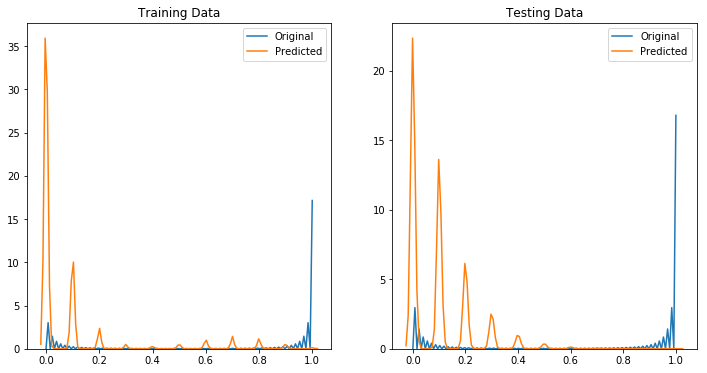

In [41]:
# Define the figure
fig, ax = plt.subplots(ncols=2, figsize=(12,6))

# Plot the training data
sns.kdeplot(y_train, ax=ax[0], label='Original').set_title('Training Data')
sns.kdeplot(predicted_train_values, ax=ax[0], label='Predicted')

# Plot the test data
sns.kdeplot(y_test, ax=ax[1], label='Original').set_title('Testing Data')
sns.kdeplot(predicted_test_values, ax=ax[1], label='Predicted')

In [42]:
# # Create a list for min_samples_leaf tuning
# samples_leaf_range = [10, 15, 20]

# # Create the Pipeline with RandomForestClassifier
# for leaf in samples_leaf_range:

#     rfPipeline = Pipeline([
#         ('union', process_join_features),
#         ('clf', RandomForestClassifier(min_samples_leaf=leaf))
#     ])

#     rfPipeline.fit(X_train, y_train)
    
#     predicted_test_values = rfPipeline.predict_proba(X_test)[:, -1]

#     print ('{}:     {}'.format(leaf, roc_auc_score(y_test, predicted_test_values)))

Printed Results:

10:     0.7171307189322933
15:     0.7309637130051394
20:     0.7301269155364674

It looks like the optimal leaf size is 15, so I'll go with that. Next to increase the max_depth.

In [43]:
# # Create a list for min_samples_leaf tuning
# max_depth_range = [6, 8, 10, 12]

# # Create the Pipeline with RandomForestClassifier
# for depth in max_depth_range:

#     rfPipeline = Pipeline([
#         ('union', process_join_features),
#         ('clf', RandomForestClassifier(min_samples_leaf=15, n_jobs=-1, max_depth=depth))
#     ])

#     rfPipeline.fit(X_train, y_train)
    
#     predicted_test_values = rfPipeline.predict_proba(X_test)[:, -1]

#     print ('{}:     {}'.format(depth, roc_auc_score(y_test, predicted_test_values)))

Printed Result:

6:     0.7320258475252519
8:     0.7398531876775293
10:     0.7434288521765071
12:     0.7375474218406659

It appears max_depth = 10 is optimal. Next I'll check number of estimators.

In [44]:
# # Create a list for min_samples_leaf tuning
# n_estimators_range = [100, 150, 200]

# # Create the Pipeline with RandomForestClassifier
# for estimator in n_estimators_range:

#     rfPipeline = Pipeline([
#         ('union', process_join_features),
#         ('clf', RandomForestClassifier(n_estimators = estimator, min_samples_leaf=15, n_jobs=-1, max_depth=10))
#     ])

#     rfPipeline.fit(X_train, y_train)
    
#     predicted_test_values = rfPipeline.predict_proba(X_test)[:, -1]

#     print ('{}:     {}'.format(estimator, roc_auc_score(y_test, predicted_test_values)))

Printed Result:

100:     0.7550486977750462
150:     0.7558829705339027
200:     0.7562810706370566

150 estimators doesn't perform much better than the 100 estimators. I'll be using the 100 estimators.

Let's combine the tuned parameters here, visualize the predictions, and write them to a csv for submission.

In [45]:
# Create the Pipeline with RandomForestClassifier
rfPipeline = Pipeline([
    ('union', process_join_features),
    ('clf', RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=15))
])

rfPipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('numeric', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x00000204BB1AB950>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecat...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [46]:
predicted_train_values = rfPipeline.predict_proba(X_train)[:, -1]
predicted_test_values = rfPipeline.predict_proba(X_test)[:, -1]

print (roc_auc_score(y_test, predicted_test_values))

0.7519103509804511


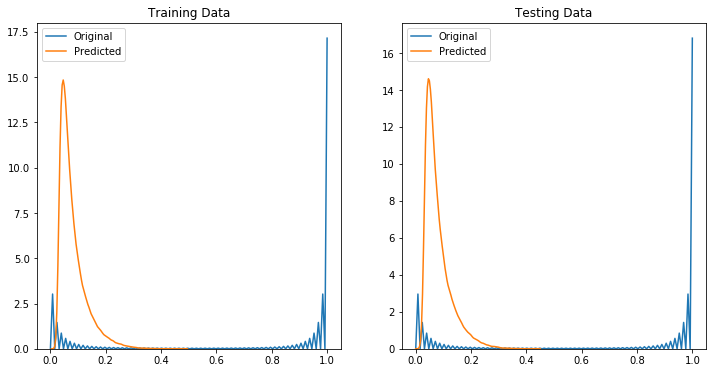

In [47]:
# Define the figure
fig, ax = plt.subplots(ncols=2, figsize=(12,6))

# Plot the training data
sns.kdeplot(y_train, ax=ax[0], label='Original').set_title('Training Data')
sns.kdeplot(predicted_train_values, ax=ax[0], label='Predicted')

# Plot the test data
sns.kdeplot(y_test, ax=ax[1], label='Original').set_title('Testing Data')
sns.kdeplot(predicted_test_values, ax=ax[1], label='Predicted')

The plot looks visibly smoothed compared to the pre-tuning.

In [48]:
# Generate the predictions from the pipeline
rfPredicted = rfPipeline.predict_proba(test_df)[:, -1]

# Create the submission dataframe
rfPredictions = submission(rfPredicted)

# Write the predictions to a csv file
rfPredictions.to_csv('./Submissions//rfPredictions.csv', encoding='utf-8', index=False)

 #### LinearSVC

In [49]:
# Create the Pipeline with LinearSVC
svcPipeline = Pipeline([
    ('union', process_join_features),
    ('clf', LinearSVC())
])

# Fit the Pipeline with the training data
svcPipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('numeric', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x00000204BB1AB950>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecat...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [50]:
predicted_train_values = svcPipeline.decision_function(X_train)#[:, -1]
predicted_test_values = svcPipeline.decision_function(X_test)#[:, -1]

In [51]:
predicted_train_values

array([-0.99550642, -0.65061646, -1.06608582, ..., -0.97884649,
       -1.00128244, -0.64733025])

In [52]:
print (roc_auc_score(y_test, predicted_test_values))

0.7394540137744716


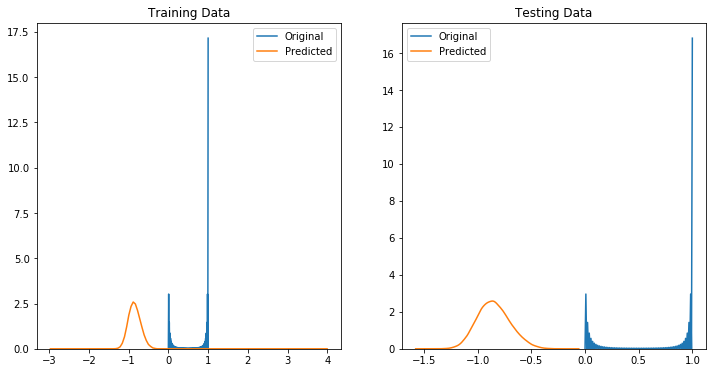

In [53]:
# Define the figure
fig, ax = plt.subplots(ncols=2, figsize=(12,6))

# Plot the training data
sns.kdeplot(y_train, ax=ax[0], label='Original').set_title('Training Data')
sns.kdeplot(predicted_train_values, ax=ax[0], label='Predicted')

# Plot the test data
sns.kdeplot(y_test, ax=ax[1], label='Original').set_title('Testing Data')
sns.kdeplot(predicted_test_values, ax=ax[1], label='Predicted')

In [54]:
# Normalize the training predictions
predicted_train_values = (predicted_train_values-predicted_train_values.
                          min()) / (predicted_train_values.max()-predicted_train_values.min())

# Normalize the testing predictions
predicted_test_values = (predicted_test_values-predicted_test_values.
                          min()) / (predicted_test_values.max()-predicted_test_values.min())

In [55]:
print (roc_auc_score(y_test, predicted_test_values))

0.7394540137744716


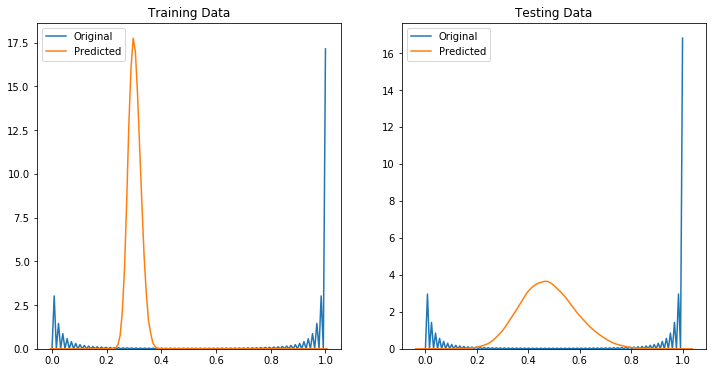

In [56]:
# Define the figure
fig, ax = plt.subplots(ncols=2, figsize=(12,6))

# Plot the training data
sns.kdeplot(y_train, ax=ax[0], label='Original').set_title('Training Data')
sns.kdeplot(predicted_train_values, ax=ax[0], label='Predicted')

# Plot the test data
sns.kdeplot(y_test, ax=ax[1], label='Original').set_title('Testing Data')
sns.kdeplot(predicted_test_values, ax=ax[1], label='Predicted')

In [57]:
# Generate the predictions from the pipeline
svcPredicted = svcPipeline.decision_function(test_df)#[:, -1]

# Create the submission dataframe
svcPredictions = submission(svcPredicted)

In [58]:
# Normalize the predictions
svcPredictions['TARGET'] =(svcPredictions['TARGET']-svcPredictions['TARGET'].
                min())/(svcPredictions['TARGET'].max()-svcPredictions['TARGET'].min())

In [59]:
# Write the predictions to a csv file
svcPredictions.to_csv('./Submissions//svcPredictions.csv', encoding='utf-8', index=False)


### XGBClassifier

In [60]:
# Create the Pipeline with XGBClassifier
# Use the paramters define in the LogisticRegression and RandomForest
xgbPipeline = Pipeline([
    ('union', process_join_features),
    ('clf', xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, 
                              reg_lambda= 0.01, max_depth=10, seed=123, n_jobs=-1))
])

# Fit the classifier to the training set
xgbPipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('numeric', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x00000204BB1AB950>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecat...te=0, reg_alpha=0, reg_lambda=0.01, scale_pos_weight=1,
       seed=123, silent=True, subsample=1))])

In [61]:
predicted_train_values = xgbPipeline.predict_proba(X_train)[:, -1]
predicted_test_values = xgbPipeline.predict_proba(X_test)[:, -1]

In [62]:
print (roc_auc_score(y_test, predicted_test_values))

0.7660135659857485


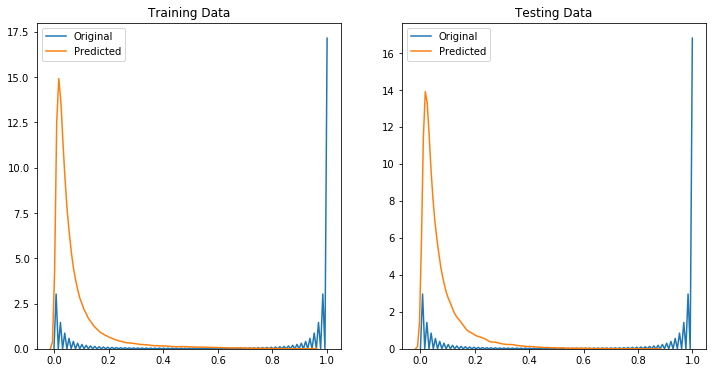

In [63]:
# Define the figure
fig, ax = plt.subplots(ncols=2, figsize=(12,6))

# Plot the training data
sns.kdeplot(y_train, ax=ax[0], label='Original').set_title('Training Data')
sns.kdeplot(predicted_train_values, ax=ax[0], label='Predicted')

# Plot the test data
sns.kdeplot(y_test, ax=ax[1], label='Original').set_title('Testing Data')
sns.kdeplot(predicted_test_values, ax=ax[1], label='Predicted')

Let's try some hyperparameter tuning. I'll tune all the previously pre-defined parameters as well as eta and colsample_bytree

In [64]:
# # Create a list for min_samples_leaf tuning
# max_depth_range = [5, 10, 15]

# # Create the Pipeline with RandomForestClassifier
# for depth in max_depth_range:

#     # Create the Pipeline with XGBClassifier
#     xgbPipeline = Pipeline([
#         ('union', process_join_features),
#         ('clf', xgb.XGBClassifier(objective='binary:logistic', max_depth=depth, seed=123, n_jobs=-1))
#     ])

#     # Fit the classifier to the training set
#     xgbPipeline.fit(X_train, y_train)
    
#     # Define the predicted values
#     predicted_test_values = xgbPipeline.predict_proba(X_test)[:, -1]
    
#     # Print the result
#     print ('{}:       {}'.format(depth, roc_auc_score(y_test, predicted_test_values)))

Printed Results:

5:       0.7639740287599673
10:       0.7654977378107681
15:       0.7554251895959663

max_depth = 10 yielded the best results.

In [65]:
# # # Create a list for regularization parameter tuning
# lambda_range = [0.001, 0.01, 0.1, 10, 100]

# # Create the Pipeline with RandomForestClassifier
# for lam in lambda_range:

#     # Create the Pipeline with XGBClassifier
#     xgbPipeline = Pipeline([
#         ('union', process_join_features),
#         ('clf', xgb.XGBClassifier(objective='binary:logistic', max_depth=10, reg_lambda = lam, seed=123, n_jobs=-1))
#     ])

#     # Fit the classifier to the training set
#     xgbPipeline.fit(X_train, y_train)
    
#     # Define the predicted values
#     predicted_test_values = xgbPipeline.predict_proba(X_test)[:, -1]
    
#     # Print the result
#     print ('{}:       {}'.format(lam, roc_auc_score(y_test, predicted_test_values)))

Printed Result:

0.001:       0.7625337742867303
0.01:       0.7631276674013077
0.1:       0.7642729817370145
10:       0.7690940499363457
100:       0.7672231838967354

It looks like a stronger regularization is better for the model. reg_lambda = 10 yielded the best result

In [66]:
# # # Create a list for regularization parameter tuning
# eta_range = [0.001, 0.01, 0.1, 1]

# # Create the Pipeline with RandomForestClassifier
# for eta in eta_range:

#     # Create the Pipeline with XGBClassifier
#     xgbPipeline = Pipeline([
#         ('union', process_join_features),
#         ('clf', xgb.XGBClassifier(objective='binary:logistic', max_depth=10, reg_lambda = 10, 
#                                   learning_rate = eta, seed=123, n_jobs=-1))
#     ])

#     # Fit the classifier to the training set
#     xgbPipeline.fit(X_train, y_train)
    
#     # Define the predicted values
#     predicted_test_values = xgbPipeline.predict_proba(X_test)[:, -1]
    
#     # Print the result
#     print ('{}:       {}'.format(eta, roc_auc_score(y_test, predicted_test_values)))

Printed Result:

0.001:       0.7055269694739909
0.01:       0.7280792399189713
0.1:       0.7690940499363457
1:       0.6997006831921699

Optimal learning_rate=0.1

In [67]:
# # # Create a list for regularization parameter tuning
# colsample_range = [0.1, 0.5, 0.8, 1]

# # Create the Pipeline with RandomForestClassifier
# for val in colsample_range:

#     # Create the Pipeline with XGBClassifier
#     xgbPipeline = Pipeline([
#         ('union', process_join_features),
#         ('clf', xgb.XGBClassifier(objective='binary:logistic', max_depth=10, reg_lambda = 10, 
#                                   learning_rate = 0.1, colsample_bytree=val, seed=123, n_jobs=-1))
#     ])

#     # Fit the classifier to the training set
#     xgbPipeline.fit(X_train, y_train)
    
#     # Define the predicted values
#     predicted_test_values = xgbPipeline.predict_proba(X_test)[:, -1]
    
#     # Print the result
#     print ('{}:       {}'.format(val, roc_auc_score(y_test, predicted_test_values)))

Printed Results:

0.1:       0.7613843525868422
0.5:       0.7690363114178909
0.8:       0.7694199370922308
1:       0.7690940499363457

Although not by much, colsample_bytree = 0.8 performs better than the default value of 1.

Let's redefine the model with these newly tuned parameters. I will make my predictions based on them and visualize the predictions.

In [68]:
# Create the Pipeline with XGBClassifier
# Use the paramters define in the LogisticRegression and RandomForest
xgbPipeline = Pipeline([
    ('union', process_join_features),
    ('clf', xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, 
                              learning_rate = 0.1, colsample_bytree = 0.8, reg_lambda= 10, 
                              max_depth=10, seed=123, n_jobs=-1))
])

# Fit the classifier to the training set
xgbPipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('numeric', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x00000204BB1AB950>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecat...tate=0, reg_alpha=0, reg_lambda=10, scale_pos_weight=1,
       seed=123, silent=True, subsample=1))])

In [69]:
predicted_train_values = xgbPipeline.predict_proba(X_train)[:, -1]
predicted_test_values = xgbPipeline.predict_proba(X_test)[:, -1]

print (roc_auc_score(y_test, predicted_test_values))

0.7712145426737702


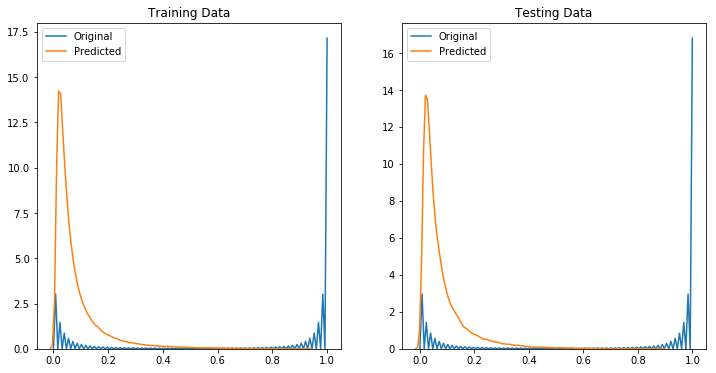

In [70]:
# Define the figure
fig, ax = plt.subplots(ncols=2, figsize=(12,6))

# Plot the training data
sns.kdeplot(y_train, ax=ax[0], label='Original').set_title('Training Data')
sns.kdeplot(predicted_train_values, ax=ax[0], label='Predicted')

# Plot the test data
sns.kdeplot(y_test, ax=ax[1], label='Original').set_title('Testing Data')
sns.kdeplot(predicted_test_values, ax=ax[1], label='Predicted')

Compared to the pre-tuning, this model appears more smoothed.

In [71]:
# Generate the predictions from the pipeline
xgbPredicted = xgbPipeline.predict_proba(test_df)[:, -1]

# Create the submission dataframe
xgbPredictions = submission(xgbPredicted)

# Write the predictions to a csv file
xgbPredictions.to_csv('./Submissions//xgbPredictions.csv', encoding='utf-8', index=False)